In [52]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import model_selection
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn import metrics
from sklearn import neighbors

from catboost import CatBoostClassifier

import optuna
from hyperopt import hp, fmin, tpe, Trials, space_eval

# from tensorflow.keras.utils import to_categorical

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [26]:
from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.utils import to_categorical

# IO utils


In [27]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [28]:
palm_file = './data/2023-05-31_17-14-41.palm'
gestures = read_omg_csv(palm_file, 
                              n_omg_channels=50,
                              n_acc_channels=3, 
                              n_gyr_channels=3, 
                              n_enc_channels=6, 
                              n_mag_channels=0)

print(gestures.shape)
gestures.head()

(19568, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,12,8,5,6,2,4,5,7,14,8,...,-13,0,0,0,0,0,0,0,0,555777
1,13,8,4,5,3,0,5,4,9,10,...,-16,0,0,0,0,0,0,0,0,555810
2,12,5,9,5,0,0,6,5,10,9,...,-14,0,0,0,0,0,0,0,0,555843
3,10,7,6,4,1,0,4,6,7,8,...,-12,0,0,0,0,0,0,0,0,555876
4,12,6,6,7,3,2,6,7,9,12,...,-12,0,0,0,0,0,0,0,0,555909


In [29]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [30]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


In [31]:
gestures[OMG_CH].values[0]

array([  12,    8,    5,    6,    2,    4,    5,    7,   14,    8,    0,
         13, 2783,   36,    4,    0, 3193, 1827,    8,    4,   26, 2763,
       2299,   10,    2,    0,   34, 2562, 1969,   11, 3199, 2597,   38,
          5,    2,    4,    7,   33, 3184, 1639,   42,   26,   14,   11,
          2,    2,   10,   12,   44,   28])

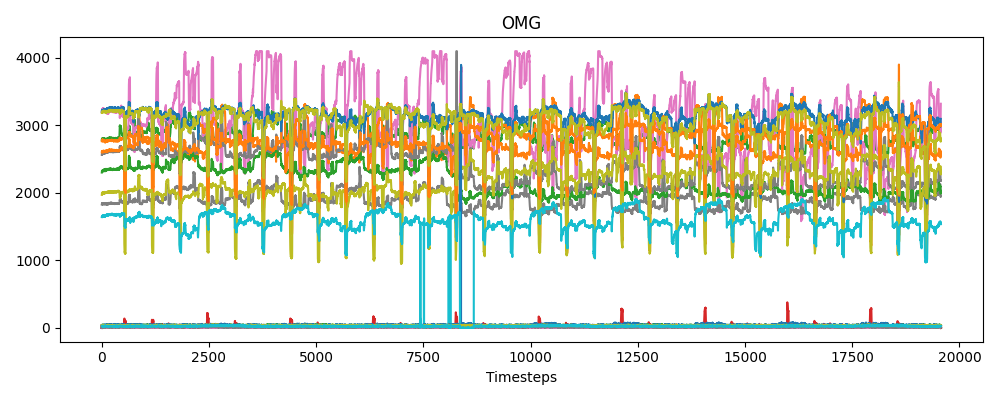

In [32]:
fig = plt.figure(figsize=(10, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

### Protocol

In [33]:
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
gestures_protocol.head(10)

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5


In [34]:
gestures['SYNC'].value_counts()

SYNC
0      11266
57        58
67        58
97        47
135       47
       ...  
52        46
1         45
103       45
104       45
12        39
Name: count, Length: 181, dtype: int64

In [35]:
le = LabelEncoder()

# FIT
le.fit(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

# TRANSFORM
gestures_protocol['gesture'] = le.transform(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
    
display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

In [36]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [37]:
gestures_protocol['gesture']

epoch
0      0
1      0
2      3
3      5
4      1
      ..
176    3
177    5
178    1
179    4
180    2
Name: gesture, Length: 181, dtype: int64

In [38]:
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
y_cmd

array([0, 0, 0, ..., 0, 0, 0])

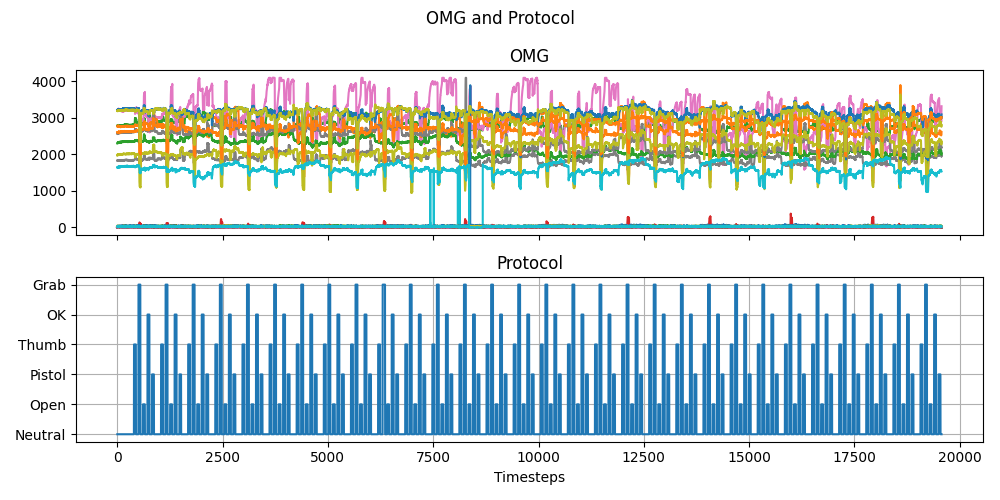

In [39]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

---

### Экспоненциальное среднее за 10 временных промежутков

Создание нового признака - Экспоненциальное среднее за 10 временных промежутков

In [40]:
df = gestures[OMG_CH]

In [41]:
def add_ewm_feature(df, span=10):
    """
    Функция для добавления столбцов с экспоненциально взвешенными скользящими 
    средними (ewm) для каждого признака в DataFrame.

    Args:
        df (DataFrame): Исходный DataFrame
        span (int): Параметр span для расчета ewm (по умолчанию 10)
    Returns:
        DataFrame: DataFrame с добавленными столбцами 'ewm' для каждого признака
    """
    for col in df.columns:
        df[f'{col}_ewm'] = df[col].ewm(span=span, adjust=False).mean()
        df = df.drop(col, axis=1)
    
    return df

In [42]:
df_ewm = add_ewm_feature(df)
df_ewm

/var/folders/q_/7gwj_d0j19x6bt29_k4ngwl40000gq/T/ipykernel_16311/3047308066.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_ewm'] = df[col].ewm(span=span, adjust=False).mean()


,0_ewm,1_ewm,2_ewm,3_ewm,4_ewm,5_ewm,6_ewm,7_ewm,8_ewm,9_ewm,...,40_ewm,41_ewm,42_ewm,43_ewm,44_ewm,45_ewm,46_ewm,47_ewm,48_ewm,49_ewm
0,12.000000,8.000000,5.000000,6.000000,2.000000,4.000000,5.000000,7.000000,14.000000,8.000000,...,42.000000,26.000000,14.000000,11.000000,2.000000,2.000000,10.000000,12.000000,44.000000,28.000000
1,12.181818,8.000000,4.818182,5.818182,2.181818,3.272727,5.000000,6.454545,13.090909,8.363636,...,40.727273,25.454545,14.000000,10.454545,2.181818,1.818182,10.000000,12.363636,41.818182,27.818182
2,12.148760,7.454545,5.578512,5.669421,1.785124,2.677686,5.181818,6.190083,12.528926,8.479339,...,40.231405,26.826446,14.000000,10.190083,2.148760,1.487603,11.636364,12.661157,41.669421,27.669421
3,11.758077,7.371901,5.655147,5.365890,1.642374,2.190834,4.966942,6.155522,11.523666,8.392186,...,39.643877,25.585274,14.000000,10.155522,2.303531,1.217130,11.702479,12.359128,39.911345,27.547708
4,11.802063,7.122464,5.717847,5.663001,1.889215,2.156137,5.154771,6.309064,11.064818,9.048152,...,39.526808,24.751588,14.000000,10.309064,2.430162,1.177652,12.120210,12.293832,40.291100,27.993580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19563,10.696319,6.507374,5.263670,4.889079,2.104665,0.959143,4.939735,4.455490,9.843683,8.764628,...,33.920912,22.776568,13.243029,10.021653,2.440108,1.984081,10.821360,12.450698,34.707681,27.280846
19564,13.478806,6.415124,5.215730,4.545610,2.085635,0.966572,4.768874,4.372674,9.690286,8.443786,...,34.298928,22.453555,13.198842,10.017716,2.541907,1.986975,10.672022,12.368753,34.579012,27.229783
19565,13.573569,6.521465,5.358324,4.446408,2.070065,0.790831,4.992715,4.486733,10.292052,8.363098,...,34.426396,22.916545,13.344507,10.559950,2.625196,1.807525,10.913472,12.301707,35.019192,27.188005
19566,16.560193,6.426653,5.474993,4.365243,2.057326,0.647044,4.994039,4.580054,10.238952,7.933444,...,34.167051,22.386264,11.645505,10.276322,2.693343,1.478884,11.292841,12.065033,35.379339,27.153822


### Корреляция df_ewm

['12_ewm', '17_ewm', '20_ewm', '21_ewm', '28_ewm', '29_ewm', '31_ewm', '38_ewm', '39_ewm', '49_ewm']


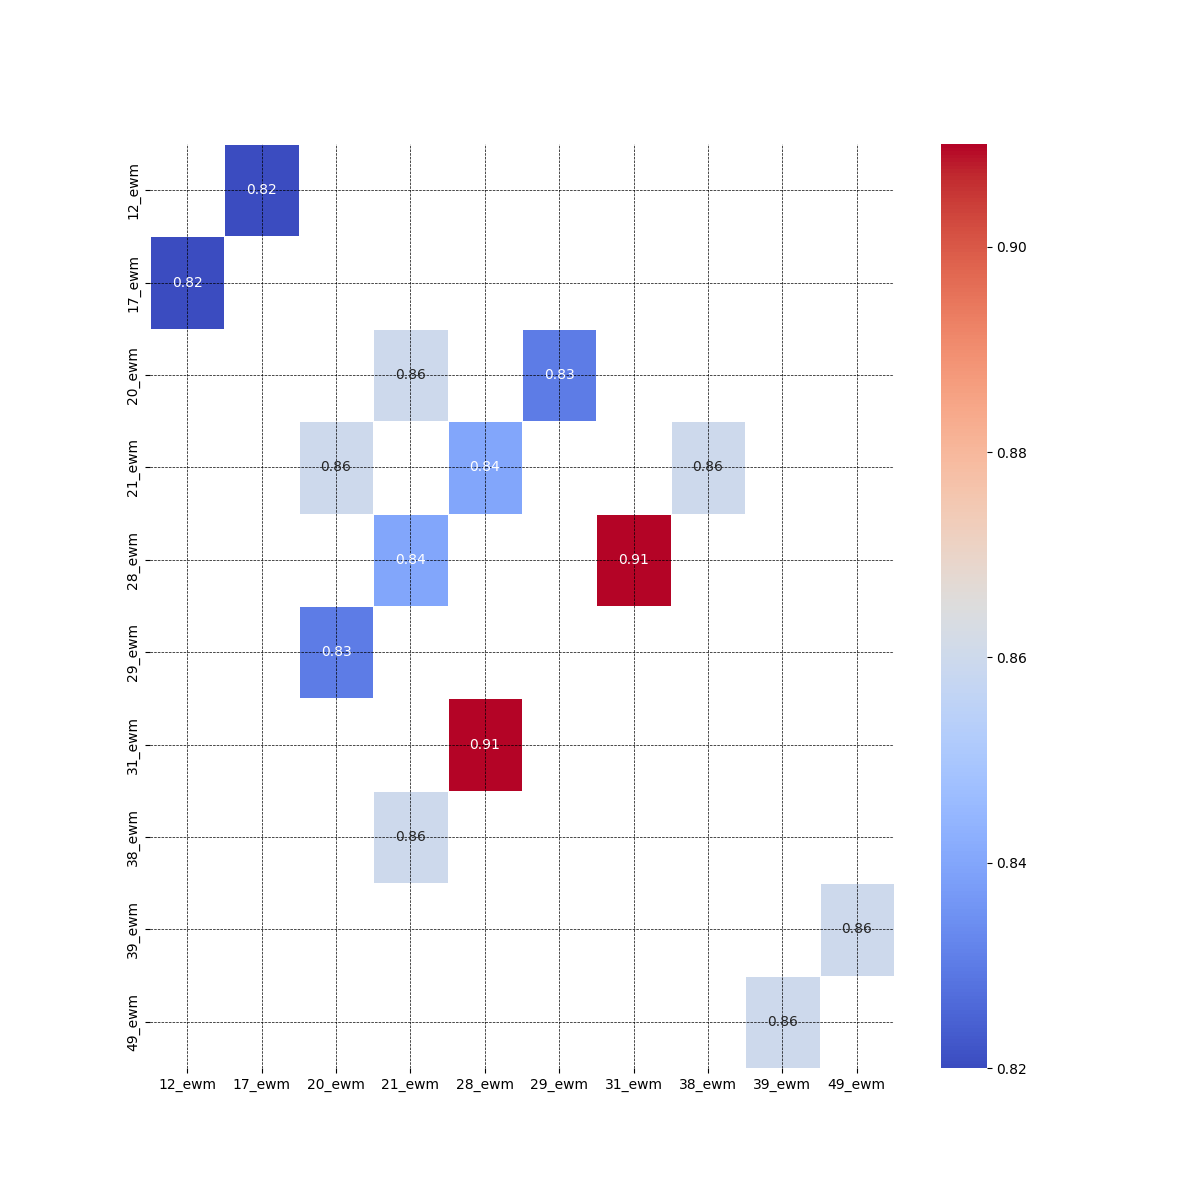

In [43]:
import seaborn as sns


def high_corr_plot(df, threshold=0.8, figsize = (12,12)):
    
    """
    Функция для отображения тепловой карты с высокой корреляцией между признаками.

    Args:
        df (DataFrame): Исходный DataFrame с признаками
        threshold (float): Порог корреляции для выделения высоких значений (по умолчанию 0.8)
        figsize (tuple): Размер фигуры для графика (по умолчанию (12, 12))
    
    Returns:
        None
    """
    
    corr_matrix = df.corr().round(decimals=2)

    # Создаем фигуру для графика
    fig_1, ax = plt.subplots(figsize = figsize)

    # Отбираем только те значения, которые имеют высокую корреляцию
    high_corr_matrix = corr_matrix[(corr_matrix > threshold) & (corr_matrix < 1) | (corr_matrix < -threshold) & (corr_matrix > -1)]

    # Удаляем строки и столбцы с низкой корреляцией
    high_corr_matrix = high_corr_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')
        
    cols = list(high_corr_matrix.columns)
    print(cols)
    # Рисуем тепловую карту
    sns.heatmap(high_corr_matrix, annot=True, cmap='coolwarm', linewidths=.5, ax=ax)
    plt.grid(True, linestyle='--', linewidth=0.5, c='black')
    plt.show()

high_corr_plot(df_ewm)

In [44]:
def get_redundant_pairs(df):
    """
    Получает диагональные и нижние треугольные пары корреляционной матрицы.

    Args:
        df (DataFrame): Исходный DataFrame с признаками

    Returns:
        set: Набор пар, которые следует исключить как избыточные
    """
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, threshold = 0.8):
    """
    Возвращает верхние абсолютные значения корреляции между признаками.

    Args:
        df (DataFrame): Исходный DataFrame с признаками
        threshold (float): Порог корреляции для выделения высоких значений (по умолчанию 0.8)

    Returns:
        DataFrame: DataFrame с отсортированными по убыванию значениями корреляции,
                   превышающими порог и не достигающими 1
    """
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    au_corr = au_corr.reset_index()
    au_corr.columns = ['Feature_1', 'Feature_2', 'Correlation']
    filtered_values = au_corr[(au_corr['Correlation'] > threshold) & (au_corr['Correlation'] < 1)]
    return filtered_values

print("Top Absolute Correlations")
high_corr = get_top_abs_correlations(df_ewm)
high_corr

Top Absolute Correlations


,Feature_1,Feature_2,Correlation
0,28_ewm,31_ewm,0.909039
1,21_ewm,38_ewm,0.859424
2,39_ewm,49_ewm,0.857956
3,20_ewm,21_ewm,0.855403
4,21_ewm,28_ewm,0.837513
5,20_ewm,29_ewm,0.825568
6,12_ewm,17_ewm,0.817415
7,23_ewm,33_ewm,0.803670


Найдем корреляцию признаков с целевой переменной, чтобы определить какие из них оставить

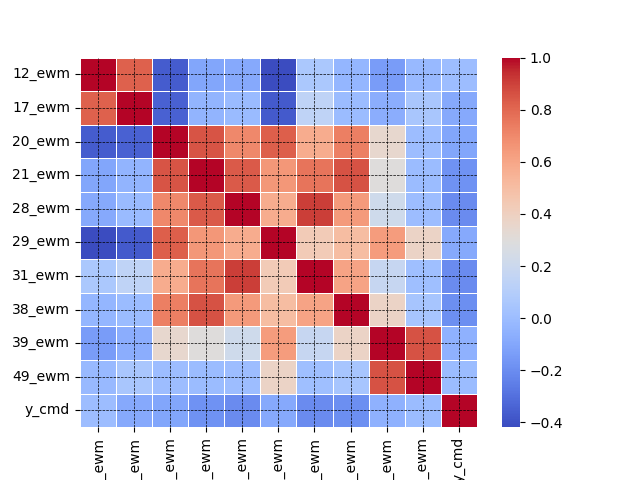

In [45]:
list_columns = ['12_ewm', '17_ewm', '20_ewm', '21_ewm', '28_ewm', '29_ewm', '31_ewm', '38_ewm', '39_ewm', '49_ewm']

temp_df = pd.DataFrame({col: df_ewm[col] for col in list_columns})
temp_df['y_cmd'] = y_cmd

correlation_matrix = temp_df.corr()
correlation_with_target = correlation_matrix['y_cmd'].drop('y_cmd')

fig, ax = plt.subplots()
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=.5, ax=ax)
plt.grid(True, linestyle='--', linewidth=0.5, c='black')
plt.show()

Так как все признаки не имеют высокой корреляции с таргетом, принято решение просто удалить один признак из каждой пары

In [46]:
col_to_drop = ['21_ewm', '20_ewm', '28_ewm', '39_ewm', '12_ewm', '23_ewm']
df_ewm = df_ewm.drop(col_to_drop, axis=1)

get_top_abs_correlations(df_ewm)

,Feature_1,Feature_2,Correlation


---

# Train-test split

In [47]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta.head()

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441


In [48]:
last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
last_train_idx

15679

___

In [49]:
X_train = df_ewm.values[:last_train_idx]
y_train = y_cmd[:last_train_idx]

X_test = df_ewm.values[last_train_idx:]
y_test = y_cmd[last_train_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15679, 44) (15679,)
(3889, 44) (3889,)


In [55]:
def get_graphs(X_array, y_array, start=1000, end=1500):
    
    _, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
    plt.suptitle(f'OMG and Protocol {start}:{end}')
    ax1.plot(X_array[start:end])
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('OMG')
    plt.grid(axis='x')
    ax2 = ax1.twinx()
    ax2.plot(y_array[start:end], 'b-')
    ax2.set_ylabel('y_cmd')
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.show()

## Глобальное устранение лага между сигналами датчиков и таргетом

In [53]:
def get_naive_centering(X_arr, y_arr, inter=1000, gap=500, window=20, model=svm.SVC()):
    # part of the data from the beginning
    X_part1 = X_arr[gap:gap+inter]
    y_part1 = y_arr[gap:gap+inter]
    # part of the data from the end
    X_part2 = X_arr[-gap-inter:-gap]
    y_part2 = y_arr[-gap-inter:-gap]
    
    def shifter(y_arr, window=20):
        first_element = y_arr[0]
        prefix = np.full(window, first_element)
        y_arr_shifted = np.concatenate((prefix, y_arr))[:-window]
    
        return y_arr_shifted
    
    
    def get_score(X, y, model=model):
        model = model
        model.fit(X, y)
        preds = model.predict(X)
        
        return metrics.accuracy_score(y, preds)
    
    
    max_score1, current_score1 = 0, 0
    max_score2, current_score2 = 0, 0
    w1, w2 = 1, 1
    # Раскомментив флаги можно вкл функционал ранней остановки
    # flag1, flag2 = True, True
    
    for i in range(1, window+1):
        y_a = shifter(y_part1, window=i)
        y_b = shifter(y_part2, window=i)
        
        current_score1 = get_score(X_part1, y_a)
        current_score2 = get_score(X_part2, y_b)
        
        if current_score1 > max_score1:
            max_score1, current_score1 = current_score1, max_score1
            w1 = i
        # else:
        #     flag1 = False
        
        if current_score2 > max_score2:
            max_score2, current_score2 = current_score2, max_score2
            w2 = i
        # else:
        #     flag2 = False
        
        # if all([flag1, flag2]) == False:
        #     break
    
    optimal_shift = round((w1+w2)/2)
    y_arr_shifted = shifter(y_arr, window=optimal_shift)
    summary = [
        f'Оптимальные свдиги для концевых выборок: {w1} и {w2}\n',
        f'Точность модели на концевых выборках:    {max_score1}; {max_score2}\n',
        f'Размер оптимального сдвига:              {optimal_shift}'
    ]
    
    return y_arr_shifted, summary

In [54]:
fitting_model = svm.LinearSVC(dual='auto')
y_train_shifted, summary = get_naive_centering(X_train, y_train, window=30, model=fitting_model)
print('Train sample shifting:\n', *summary, '\n', sep='')
y_test_shifted, summary = get_naive_centering(X_test, y_test, window=30, model=fitting_model)
print('Test sample shifting:\n', *summary, sep='')

Train sample shifting:
Оптимальные свдиги для концевых выборок: 24 и 22
Точность модели на концевых выборках:    0.99; 0.994
Размер оптимального сдвига:              23

Test sample shifting:
Оптимальные свдиги для концевых выборок: 28 и 28
Точность модели на концевых выборках:    0.99; 0.995
Размер оптимального сдвига:              28


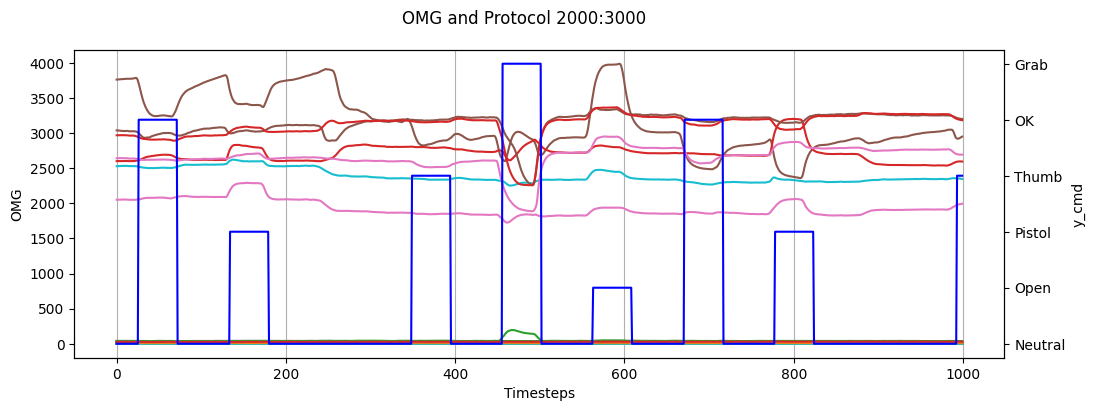

In [56]:
get_graphs(X_train, y_train_shifted, start=2000, end=3000)

### AA - Scaler

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition

In [58]:
std_scaler = StandardScaler()
std_scaler.fit(X_train)

X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.fit_transform(X_test)

In [59]:
# Определяем метод таким образом, чтобы отобранные им
# компоненты объясняли не менее 99,0 % разброса данных
pca = decomposition.PCA(n_components=0.99, random_state=42).fit(X_train_scaled)
# Обучаем алгоритм на наших данных
print(f'Число компонент: {len(pca.components_)}')

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

Число компонент: 39


# Modeling

In [38]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate as cv
from sklearn.model_selection import GridSearchCV

In [39]:
def cv_metrics(model, kfold=KFold()):
    
    """
    Вычисляет метрики на кросс-валидации для заданной модели.

    Параметры:
    - model: оцениваемая модель
    - kfold: стратегия кросс-валидации, по умолчанию KFold()

    Вывод:
    - Средние значения f1_weighted на тренировочных и валидационных фолдах
    """
    
    cv_metrics = cv(
        estimator=model,
        X=X_train_pca,
        y=y_train,
        scoring='f1_weighted',
        cv = kfold,
        return_train_score=True
    )
    
    print('Train k-fold mean f1_weighted: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
    print('Valid k-fold mean f1_weighted: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
    
def best_model_param(model, param_grid):
    
    """
    Выполняет поиск лучших параметров модели с использованием GridSearchCV.

    Параметры:
    - model: оцениваемая модель
    - param_grid: сетка параметров для поиска

    Вывод:
    - Лучшие параметры найденной модели
    """
    
    cv_metrics(model)
    
    grid_search = GridSearchCV(
        estimator= model, 
        param_grid=param_grid, 
        n_jobs = -1
    )
    
    grid_search.fit(X_train_pca, y_train)
    
    print(f'\nBest model has such params: {grid_search.best_params_}\n')
    
    cv_metrics(grid_search.best_estimator_)
    
    return grid_search.best_estimator_

In [40]:
from sklearn.tree import DecisionTreeClassifier

# model = DecisionTreeClassifier(random_state = 42)

# params = {'criterion': ['gini', 'entropy'], 
#                 'max_depth': range(1,7), 
#                 'min_samples_leaf': range(1,5)
#                 }

# tree_best_params = best_model_param(model, params)

Train k-fold mean f1_weighted: 1.00
Valid k-fold mean f1_weighted: 0.72

Best model has such params: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 4}

Train k-fold mean f1_weighted: 0.78
Valid k-fold mean f1_weighted: 0.75


In [71]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    random_state=42, max_iter=1000
)

log_reg_param = {'multi_class': ['ovr', 'multinomial'], 
                'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}

grid = model_selection.GridSearchCV(
    log_reg,
    log_reg_param,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_pca, y_train_shifted)
print(grid.best_params_)
model = grid.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ......................multi_class=ovr, solver=lbfgs; total time=   0.2s
[CV] END ......................multi_class=ovr, solver=lbfgs; total time=   0.2s
[CV] END ......................multi_class=ovr, solver=lbfgs; total time=   0.2s
[CV] END ......................multi_class=ovr, solver=lbfgs; total time=   0.2s
[CV] END ......................multi_class=ovr, solver=lbfgs; total time=   0.2s
[CV] END ..................multi_class=ovr, solver=newton-cg; total time=   0.5s
[CV] END ..................multi_class=ovr, solver=newton-cg; total time=   0.6s
[CV] END ..................multi_class=ovr, solver=newton-cg; total time=   0.6s
[CV] END ..................multi_class=ovr, solver=newton-cg; total time=   0.5s
[CV] END ..................multi_class=ovr, solver=newton-cg; total time=   0.6s
[CV] END ........................multi_class=ovr, solver=sag; total time=   1.8s
[CV] END ........................multi_class=ovr,

In [60]:

from sklearn.feature_selection import RFE

In [73]:
selector = RFE(model, step=1)
selector = selector.fit(X_train_pca, y_train_shifted)

In [ ]:
# import seaborn as sns

# plt.figure(figsize=(10, 3)) # 
# sns.heatmap(model.coef_, cbar_kws={"orientation": "horizontal"})
# plt.tight_layout()

## Prediction

In [74]:
y_pred_train = selector.predict(X_train_pca)
y_pred_test = selector.predict(X_test_pca)

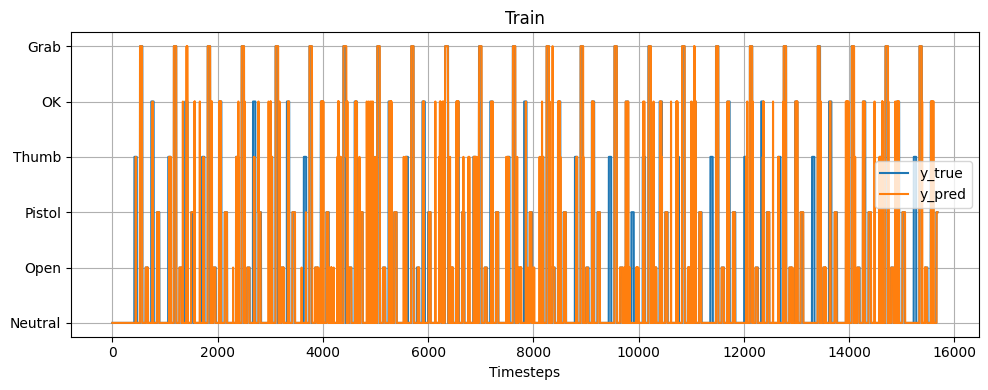

In [75]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_train_shifted,  c='C0', label='y_true')
plt.plot(y_pred_train, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

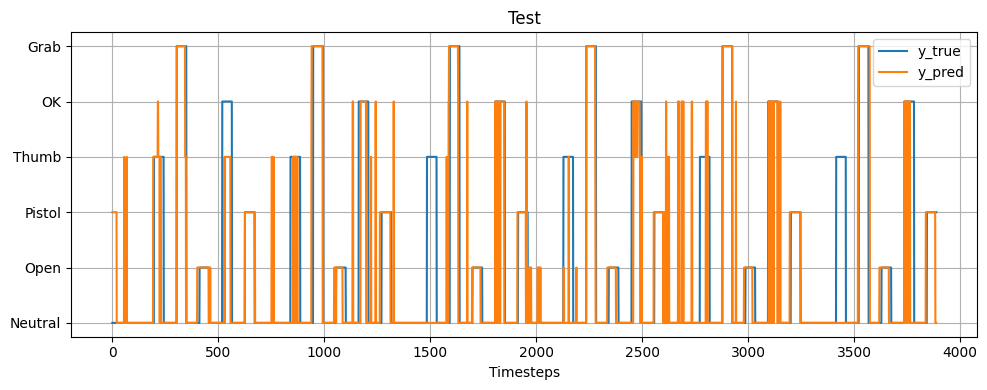

In [76]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_test_shifted,  c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [77]:
from sklearn.metrics import classification_report

print(classification_report(y_train_shifted, y_pred_train, target_names=GESTURES))
print(classification_report(y_test_shifted, y_pred_test, target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.85      0.96      0.90     10174
        Open       0.92      0.85      0.88      1104
      Pistol       0.93      0.85      0.89      1075
       Thumb       0.62      0.23      0.33      1104
          OK       0.64      0.35      0.45      1104
        Grab       0.95      0.96      0.95      1118

    accuracy                           0.85     15679
   macro avg       0.82      0.70      0.73     15679
weighted avg       0.84      0.85      0.83     15679

              precision    recall  f1-score   support

     Neutral       0.84      0.93      0.88      2509
        Open       0.77      0.77      0.77       276
      Pistol       0.84      0.93      0.88       275
       Thumb       0.34      0.13      0.19       276
          OK       0.74      0.45      0.56       276
        Grab       0.92      0.93      0.93       277

    accuracy                           0.83      3889
   macro avg       0.74

In [78]:
imp = pd.DataFrame(model.feature_importances_, index=range(X_test_pca.shape[1]), columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8));

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

# Real-time inference

In [74]:
import time
import serial
from IPython.display import clear_output

ModuleNotFoundError: No module named 'serial'

In [ ]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [ ]:
def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(x):
    y = model.predict([x])
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [ ]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

(3889, 65)


In [ ]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (3889, 50)
enc_sample.shape = (3889, 6)
sample_preprocessed.shape = (3889, 50)
y_predicted.shape = (3889, 1)
y_postprocessed.shape = (3889, 1)
y_commands.shape = (3889, 1)


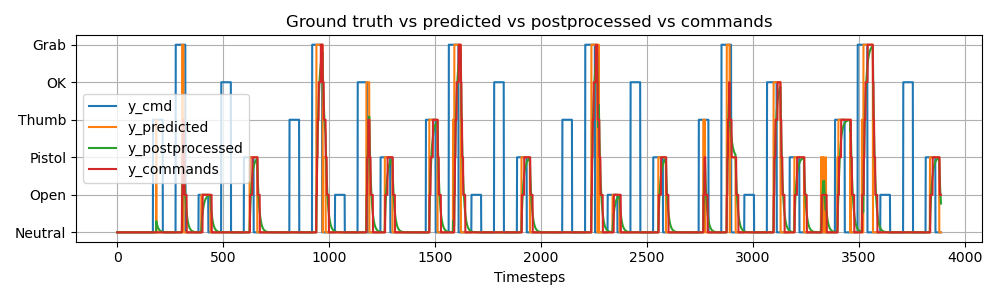

In [ ]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [ ]:
print(classification_report(y_test, y_dct['y_commands'], target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.67      0.78      0.72      2508
        Open       0.11      0.16      0.13       276
      Pistol       0.22      0.23      0.23       276
       Thumb       0.20      0.11      0.14       276
          OK       0.00      0.00      0.00       276
        Grab       0.12      0.02      0.04       277

    accuracy                           0.54      3889
   macro avg       0.22      0.22      0.21      3889
weighted avg       0.48      0.54      0.50      3889



### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 